In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
import sys
sys.path.append("/opt/anaconda3/lib/python3.11/site-packages")
import os
import git
try:
    git.Repo.clone_from("https://github.com/yeswanthkaali/models.git", "/Users/yeswanth/Library/CloudStorage/OneDrive-SoftwareAG/Desktop(2)/era_v2/Assignment11/modules_assignment/")
except:
     repo = git.Repo('/Users/yeswanth/Library/CloudStorage/OneDrive-SoftwareAG/Desktop(2)/era_v2/Assignment11/modules_assignment/')
     reo = repo.remotes.origin
     reo.pull()


In [3]:
from modules_assignment.utils import train,test,lr_finder,plt_wrongpred
from modules_assignment.models.resnet18 import ResNet18

/Users/yeswanth/anaconda3/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
simple_transform=transforms.Compose([transforms.ToTensor()])
exp_dataset=datasets.CIFAR10('./data',train=True,download=True,transform=simple_transform)

Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(exp_dataset, batch_size=len(exp_dataset), shuffle=False)
data = next(iter(train_loader))

# Calculate mean and std per channel
mean = data[0].mean(dim=(0, 2, 3))  # Calculate mean across all images and height, width dimensions
std = data[0].std(dim=(0, 2, 3))    # Calculate std across all images and height, width dimensions

print("Mean per channel:", mean)
print("Std per channel:", std)

Mean per channel: tensor([0.4914, 0.4822, 0.4465])
Std per channel: tensor([0.2470, 0.2435, 0.2616])


In [6]:
import cv2
import torchvision

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label
train_transform=A.Compose([A.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
                           A.RandomCrop (32, 32, always_apply=False, p=4),
                           A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value=None),
                            ToTensorV2()
                           
                                   ])
test_transform=A.Compose([A.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
                          ToTensorV2()
                                   ])
train_data=Cifar10SearchDataset('./data',train=True,download=True,transform=train_transform)
test_data=Cifar10SearchDataset('./data',train=False,download=True,transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? False


In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.96E-01


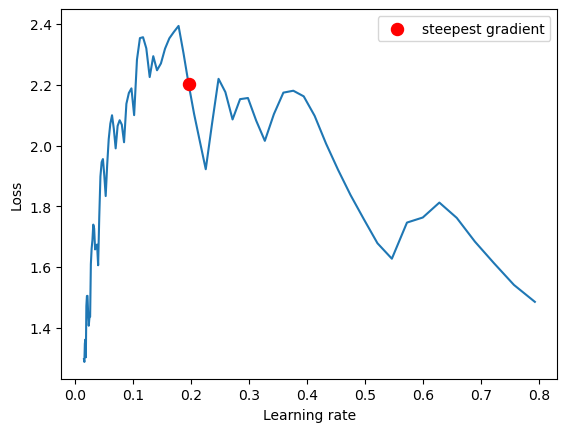

In [10]:
device = torch.device("mps")
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-2)
lr_finder(train_loader,optimizer,criterion,model,1)

In [11]:
epochs=20
device = torch.device("mps")
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-7)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.196,epochs=epochs,total_steps=len(train_loader)*epochs,div_factor=10,final_div_factor=10)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
for epoch in range(1, epochs+1):
    print(epoch)
    train_loss,train_accuracy=train(model, device, train_loader, optimizer, scheduler,criterion)
    test_loss,test_accuracy=test(model, device, test_loader,criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

1


loss=1.3520925045013428 batch_id=781 Accuracy=39.61: 100%|█| 782/782 [03:53<00:0



Test set: Average loss: 0.0238, Accuracy: 4609/10000 (46%)

2


loss=0.9697914123535156 batch_id=781 Accuracy=56.55: 100%|█| 782/782 [03:22<00:0



Test set: Average loss: 0.0173, Accuracy: 6095/10000 (61%)

3


loss=0.6651479005813599 batch_id=781 Accuracy=65.50: 100%|█| 782/782 [03:23<00:0



Test set: Average loss: 0.0142, Accuracy: 6840/10000 (68%)

4


loss=0.9247329831123352 batch_id=781 Accuracy=71.70: 100%|█| 782/782 [03:34<00:0



Test set: Average loss: 0.0112, Accuracy: 7488/10000 (75%)

5


loss=0.6803053617477417 batch_id=781 Accuracy=76.16: 100%|█| 782/782 [03:29<00:0



Test set: Average loss: 0.0097, Accuracy: 7872/10000 (79%)

6


loss=0.6763594150543213 batch_id=781 Accuracy=79.38: 100%|█| 782/782 [03:24<00:0



Test set: Average loss: 0.0084, Accuracy: 8190/10000 (82%)

7


loss=0.4563310742378235 batch_id=781 Accuracy=82.44: 100%|█| 782/782 [03:26<00:0



Test set: Average loss: 0.0080, Accuracy: 8284/10000 (83%)

8


loss=0.3277474343776703 batch_id=781 Accuracy=84.63: 100%|█| 782/782 [03:13<00:0



Test set: Average loss: 0.0082, Accuracy: 8320/10000 (83%)

9


loss=0.580280065536499 batch_id=781 Accuracy=86.95: 100%|█| 782/782 [03:12<00:00



Test set: Average loss: 0.0078, Accuracy: 8359/10000 (84%)

10


loss=0.3586587905883789 batch_id=781 Accuracy=88.86: 100%|█| 782/782 [03:04<00:0



Test set: Average loss: 0.0086, Accuracy: 8281/10000 (83%)

11


loss=0.1356101930141449 batch_id=781 Accuracy=90.52: 100%|█| 782/782 [03:29<00:0



Test set: Average loss: 0.0080, Accuracy: 8479/10000 (85%)

12


loss=0.389941930770874 batch_id=781 Accuracy=91.80: 100%|█| 782/782 [03:46<00:00



Test set: Average loss: 0.0079, Accuracy: 8545/10000 (85%)

13


loss=0.02719753235578537 batch_id=781 Accuracy=93.41: 100%|█| 782/782 [03:11<00:



Test set: Average loss: 0.0083, Accuracy: 8573/10000 (86%)

14


loss=0.08237969875335693 batch_id=781 Accuracy=94.41: 100%|█| 782/782 [03:00<00:



Test set: Average loss: 0.0080, Accuracy: 8612/10000 (86%)

15


loss=0.3804129362106323 batch_id=781 Accuracy=95.53: 100%|█| 782/782 [02:56<00:0



Test set: Average loss: 0.0083, Accuracy: 8629/10000 (86%)

16


loss=0.1776919960975647 batch_id=781 Accuracy=96.39: 100%|█| 782/782 [03:00<00:0



Test set: Average loss: 0.0082, Accuracy: 8725/10000 (87%)

17


loss=0.009187240153551102 batch_id=781 Accuracy=97.22: 100%|█| 782/782 [02:59<00



Test set: Average loss: 0.0079, Accuracy: 8745/10000 (87%)

18


loss=0.016186285763978958 batch_id=781 Accuracy=98.00: 100%|█| 782/782 [03:03<00



Test set: Average loss: 0.0084, Accuracy: 8809/10000 (88%)

19


loss=0.08392035961151123 batch_id=781 Accuracy=98.47: 100%|█| 782/782 [03:47<00:



Test set: Average loss: 0.0087, Accuracy: 8818/10000 (88%)

20


loss=0.010484516620635986 batch_id=781 Accuracy=98.54: 100%|█| 782/782 [03:52<00



Test set: Average loss: 0.0084, Accuracy: 8856/10000 (89%)



In [54]:
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
def plt_wrongpred(model,test_data,device,class_names,target_layers):
    model_eval=model.eval()
    wrong_predictions = []
    with torch.no_grad():
        for data, target in test_data:
            data, target = data.to(device), target
            output = model(data.unsqueeze(0))
            pred = torch.argmax(output, 1)# get the index of the max log-probability
            if(pred!=target):
                wrong_predictions.append((data, pred, target))
    for i in range(1,min(11, len(wrong_predictions))):
        plt.subplot(2,5,i)
        plt.axis('off')
        image, predicted, label = wrong_predictions[i]
        image_ch = image.to(device).permute(1, 2, 0)  # Rearrange dimensions for plotting (assuming channels are last)    
        # Plot the image
        gm=gradcam(image,image,model,target_layers)
        plt.imshow(gm.clamp(0,1))
        plt.title(f"{class_names[predicted]}-{class_names[label]}")
def gradcam(image,input_tensor,model,target_layers):
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
    return visualization



In [43]:
%matplotlib inline
target_layers=[model.layer3[-1]]
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt_wrongpred(model,test_data,device,class_names,target_layers)

KeyboardInterrupt: 

In [45]:
%matplotlib inline
target_layers=[model.layer3[-1]]
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
model_eval=model.eval()
wrong_predictions = []
with torch.no_grad():
    for data, target in test_data:
        data, target = data.to(device), target
        output = model(data.unsqueeze(0))
        pred = torch.argmax(output, 1)# get the index of the max log-probability
        if(pred!=target):
            wrong_predictions.append((data, pred, target))

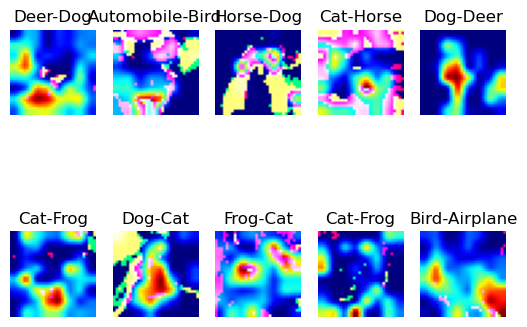

In [75]:
import numpy as np
target_layers=[model.layer3[-1]]
for i in range(1,min(11, len(wrong_predictions))):
    plt.subplot(2,5,i)
    plt.axis('off')
    image, predicted, label = wrong_predictions[i]
    device = torch.device("mps")
    image_ch = image.to(device).permute(1, 2, 0)  # Rearrange dimensions for plotting (assuming channels are last)
    img = np.float32(image_ch.cpu()) / 255
    # Plot the image
    gm=gradcam(img,image.unsqueeze(0),model,target_layers)
    plt.imshow(gm)
    plt.title(f"{class_names[predicted]}-{class_names[label]}")

In [66]:
from PIL import Image
import requests
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))

In [69]:
img.shape

(224, 224, 3)

In [68]:
import cv2
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255